<br/>

$$ \huge{\underline{\textbf{ Model Free Control - On Policy }}} $$

$$ \Large{\textbf{ Part 1 }} $$

# Introduction

This post roughly corresponds to first part of Lecture 5 of UCL RL course by David Silver.

We will explore On-Policy Monte-Carlo control and On-Policy TD (aka SARSA) control algorithm. In this post we will keep it simple. In next post we will focus on Off-Policy algorithms.

Table of contents:
* Intro
  * [Introduction](#Introduction)
  * [1D Corridor](#1D-Corridor) - update of toy environment from [previous post](../Lecture04_Pred/ModelFreePrediction_Part2.ipynb#1D-Corridor)
  * [Helper Functions](#Helper-Functions) - plotting etc.
* Monte-Carlo
  * [MC Prediction](#MC-Prediction) - Q version of MC prediction
  * [MC Control](#MC-Control) - MC prediction + e-greedy policy improvement
* On-Policy Control
  * [TD Prediction](#TD-Prediction) - Q version of TD prediction
  * [SARSA](#SARSA) - TD prediction + e-greedy policy improvement = standard SARSA
  * [N-Step SARSA](#N-Step-SARSA) - n-step version of standard SARSA
  * [Forward View SARSA(λ)](#Forward-View-SARSA(λ%29)
  * [Backward View SARSA(λ)](#Backward-View-SARSA(λ%29) - with Eligibility Traces
* On-Policy Control - online implementations
  * [Online SARSA](#Online-SARSA)
  * [Online Backward View SARSA(λ)](#Online-Backward-View-SARSA(λ%29) - with Eligibility Traces
* Other
  * [Generate REF_RANDOM](#Generate-REF_RANDOM) - ground truth

Sources:
* UCL Course on RL: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
  * Lecture 5 pdf: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/control.pdf
  * Lecture 5 vid: https://www.youtube.com/watch?v=0g4j2k_Ggc4
* Sutton and Barto 2018: http://incompleteideas.net/book/the-book-2nd.html

# 1D Corridor

In [1]:
import numpy as np
import matplotlib.pyplot as plt

This is slightly modified environment from previous chapter. In previous post we used similar corridor with zero reward everywhere and "1" reward on transition into terminal state. This was ok for policy evaluation (simple math, no discount), but to showcase agent learning I think we will be better served with slightly different version of corridor environment.

Firstly, with reward 0 (and no discount) agent is not really incentivised to promptly go to exit state. Quite the opposite. It doesn't matter if agent goes straight to exit and gets reward "1", or hangs around for a while and then exits also with reward "1". What we want is for agent to learn to get out as soon as possible, using shortest path to exit. Standard way to do this is to define reward "-1" for all state transition. This way agent is penalised for every time-step it wastes. Another modification we will do is move start state to far-left side of corridor and and replace left exit with bouncy wall. This will simplify things slightly.

<img src="assets/corridor2.png"/>

Obviously, the optimal policy is to always pick action "right".

List of changes include:
* start state is now far left
* there is wall on the left - left action from start state causes agent to bounce back
* reward per step is now -1 - this is to encourage agent to exit quickly
* corridor length is 10 (total of 11 states) - this is to speed up computation slightly

In [2]:
class LinearEnv:
    """
    Allowed states are:
    State id: [ 0 ... 10 ]
    Type:     [ S ...  T ]
    Reward:   [-1 -1   0 ]
    """
    def __init__(self):
        size = 9
        self.nb_st = size + 2   # nb states
        self.nb_act = 2         # nb actions
        self._max_left = 1      # last non-terminal state to the left
        self._max_right = size  # last non-terminal state to the right
        self._start_state = 0
        self.reset()

    def reset(self):
        self._state = self._start_state
        self._done = False
        return self._state

    def step(self, action):
        if self._done: return (self._state, 0, True)  # We are done
        if action not in [0, 1]: raise ValueError('Invalid action')

        self._state += -1 if action==0 else 1
        self._state = max(self._state, 0)   # bounce off the wall
        obs = self._state
        if self._state > self._max_right:
            reward = -1
            self._done = True
        elif self._state < self._max_left:
            reward = -1
            self._done = False
        else:
            reward = -1
            self._done = False
        return (obs, reward, self._done)

Below is good approximation of true Q-values for random policy (acquired by running MC for 100k episodes) and correct Q-values for optimal greedy policy. These will be used as ground truth in plots.

In [3]:
# Correct Q values for [0.50, 0.50] policy
REF_RANDOM = np.array([[-110.68971241, -108.685087  ],
                       [-110.66583621, -104.73818239],
                       [-108.71371977,  -98.88761006],
                       [-104.89313003,  -90.93288528],
                       [ -98.94523759,  -80.92351417],
                       [ -90.94655643,  -68.77193039],
                       [ -80.74743653,  -54.93719431],
                       [ -68.896667  ,  -38.83260026],
                       [ -54.71899209,  -20.97842456],
                       [ -38.930884  ,   -1.        ],
                       [   0.        ,    0.        ]])

# Correct Q values for [0.00, 1.00] greedy policy
REF_GREEDY = np.array([[-11., -10.],
                       [-11.,  -9.],
                       [-10.,  -8.],
                       [ -9.,  -7.],
                       [ -8.,  -6.],
                       [ -7.,  -5.],
                       [ -6.,  -4.],
                       [ -5.,  -3.],
                       [ -4.,  -2.],
                       [ -3.,  -1.],
                       [  0.,   0.]])

Let's create environment and policies for future use

In [4]:
env = LinearEnv()

pi_random = np.tile([0.50, 0.50], [11, 1])  # starting random policy
pi_greedy = np.tile([0.00, 1.00], [11, 1])  # optimal greedy policy

# Helper Functions

As in previous posts, let's get helper functions out of the way.

Function generate_episode now takes policy as a parameter and limits episode length to 1000 steps. This is because otherwise e-greedy policy with small enough e can cause agent to get "stuck" in a loop if due to learning process agent acquires intermediate policy with multiple left actions in subsequent states. In such situation to complete episode, it would have to execute low-probability right action multiple times in a row.

In [5]:
def generate_episode(env, policy):
    """Generate one complete episode"""
    trajectory = []
    done = True
    for _ in range(1000):  # limit episode length
        # === time step starts ===
        if done:
            St, Rt, done = env.reset(), None, False
        else:
            St, Rt, done = env.step(At)   
        At = np.random.choice([0, 1], p=policy[St])
        trajectory.append((St, Rt, done, At))
        if done:
            break
        # === time step ends here ===
    return trajectory

In [6]:
class LogEntry:
    """Data log for one evaluation or training run, e.g. 100 episodes"""
    def __init__(self, type_, Q_hist, perf):
        self.type = type_     # string, e.g. 'monte carlo'
        self.Q_hist = Q_hist  # history of state-values
        self.perf = perf      # agent performance (episode length)



Plots three graphs:
* q-values after evaluation/training is completed
* root-mean-squared-error (RMSE) during training process
* agent performance measured with episode length, which is equivalent to reward in our specific case

In [7]:
def plot_experiments(log, truth_ref, plot_title):
    """Plot policy evaluation process
    
    Params:
        histories - list of 3d arrays, 
            each element is np.array, each np.array is independent eval or training run
            array dim 0 is number of episodes
            array dim 1 is Q-table (which is 2d on it's own) after each episode
        performances - list of 1d arrays
            each array is independent evaluation or training run
        truth_ref - precomputed correct Q-values
    """
    fig = plt.figure(figsize=[18,6])
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    # plot ground truth
    ax1.plot(truth_ref[:-1,0], color='gray', linestyle='--')
    ax1.plot(truth_ref[:-1,1], color='gray', linestyle='--')
    
    for le in log:
        Q_vals = le.Q_hist[-1]
        ax1.plot(Q_vals[:-1,0], color='red', alpha=0.3)   # Q left
        ax1.plot(Q_vals[:-1,1], color='green', alpha=0.3) # Q right
        
        E_vals = np.sum(np.sum((truth_ref - le.Q_hist)**2, axis=-1), axis=-1)  # RMSE
        ax2.plot(E_vals, color='blue', alpha=0.3)         # RMSE
        
        ax3.plot(le.perf, color='blue', alpha=0.3)
        ax3.plot([0, len(le.perf)],[10,10], color='gray', linestyle='--')
    
    ax1.grid()
    ax1.set_title('Estimated State-Action Values')
    ax2.grid()
    ax2.set_title('Ground Truth Error')
    ax3.set_ylim([0, 1010])
    ax3.grid()
    ax3.set_title('Agent Performance')
    fig.suptitle(plot_title, fontsize=18)
                
    plt.show()

# MC Prediction

Q-Value version of running-mean monte-carlo. This is copy-paste code from Model Free Prediction post [lecture 4](../Lecture04_Pred/ModelFreePrediction_Part1.ipynb#Running-Mean-Monte-Carlo).

Changes are as follows:
* track Q-values (2d array) instead of V (1d-array)
* Gt calculation changed, this still assumes discount is always 1!
* update Q instead of V
* track history for plotting

In [8]:
def mc_prediction(env, policy, N, alpha):
    hist, perf = [], []
    
    # V = np.zeros(st_shape)            # old code
    Q = np.zeros(shape=[env.nb_st, env.nb_act])

    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            
            # Gt = trajectory[-1][1]     # old code
            Gt = -(len(trajectory)-t-1)  # -1 * nb_steps_to_end; assumes disc==1
            
            St, _, _, At = trajectory[t]
            
            # V[St] = V[St] + alpha*(Gt - V[St])  # old code
            Q[St, At] = Q[St, At] + alpha * (Gt - Q[St, At])
            
        hist.append(Q.copy())
        perf.append(len(trajectory)-1)  # don't count terminal state

    return np.array(hist), np.array(perf)

Let's evaluate random policy.

Notes:
* state-action values should roughly overlap with gray ground-truth
* error to ground-truth for random policy should decrease pretty quickly
* agent performance will not improve because we are not actually improving policy

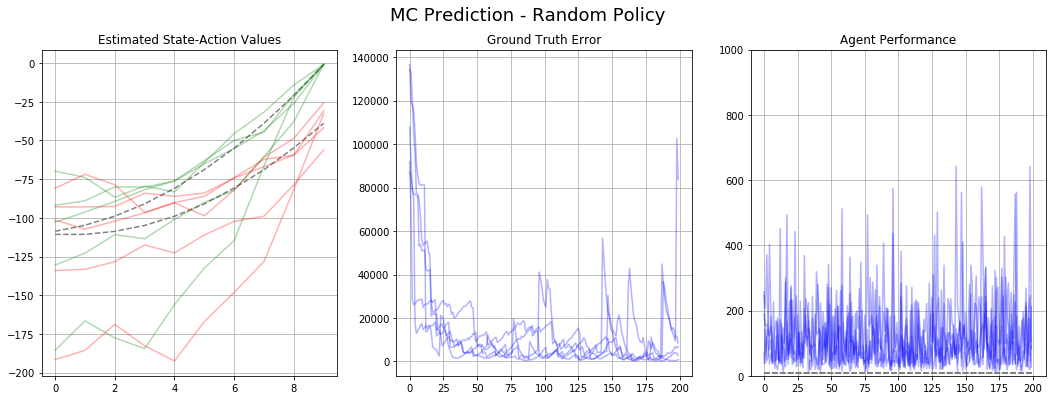

In [9]:
log = []
for _ in range(5):
    hist, perf = mc_prediction(env, pi_random, N=200, alpha=0.01)
    log.append(LogEntry('mc', hist, perf))
plot_experiments(log, REF_RANDOM, 'MC Prediction - Random Policy')

And for completeness let's evaluate greedy policy.

Notes:
* state-action values for right actions (green) overlap perfectly with gray ground truth
* state-action values for left actions (red) completely failed to evaluate (zero is initial value, they are never taken during evaluation runs)
* because state-action values for left actions are never improved, ground truth error will never converge
* agent performance is perfect, always -10 reward

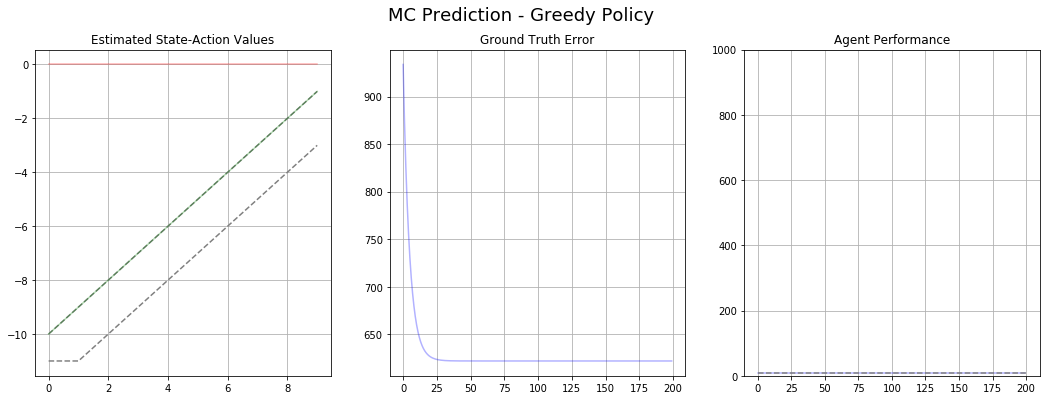

In [10]:
hist, perf = mc_prediction(env, pi_greedy, N=200, alpha=0.1)
plot_experiments([LogEntry('td', hist, perf)], REF_GREEDY, 'MC Prediction - Greedy Policy')

# MC Control

To do control, we will need a way to improve policy along the way. Normally we would _not_ precompute policy for all states after each improvement. Actually we would not precompute policy at all. Instead agent would pick actions using current Q-Values on the fly. But I think this way is slightly easier to understand. Proper version is implemented at the end of this post.

In [11]:
def make_eps_greedy(Q, eps):
    policy = np.zeros(shape=Q.shape) + eps
    maxq = np.argmax(Q, axis=-1)
    policy[range(len(policy)),maxq] = 1-eps
    return policy

This is a _running-mean_ version of MC code above. We need to track changing policy - incremental MC would keep state-action values from early training episodes forever

In [12]:
def mc_control(env, policy, N, alpha, eps):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])

    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            Gt = -(len(trajectory)-t-1)  # -1 * nb_steps_to_end; assumes disc==1
            St, _, _, At = trajectory[t]
            # Q[St, At] = Q[St, At] + (1/C[St, At]) * (Gt - Q[St, At])  # old code
            Q[St, At] = Q[St, At] + alpha * (Gt - Q[St, At])  # replace 1/C with alpha
        
        policy = make_eps_greedy(Q, eps)  # Make policy e-greedy
            
        hist.append(Q.copy())
        perf.append(len(trajectory)-1)

    return np.array(hist), np.array(perf)

Let's run full training couple of times. Notice:
* right actions (left-plot, green) converge OK-ish
* left actions (left-plot, red) take long to converge because they are taken rarely after policy is learned
* agent performance generally OK after training, but due to e-greedy policy it will never be perfect (unless we decay epsilon)
* MC high variance takes its toll on training time

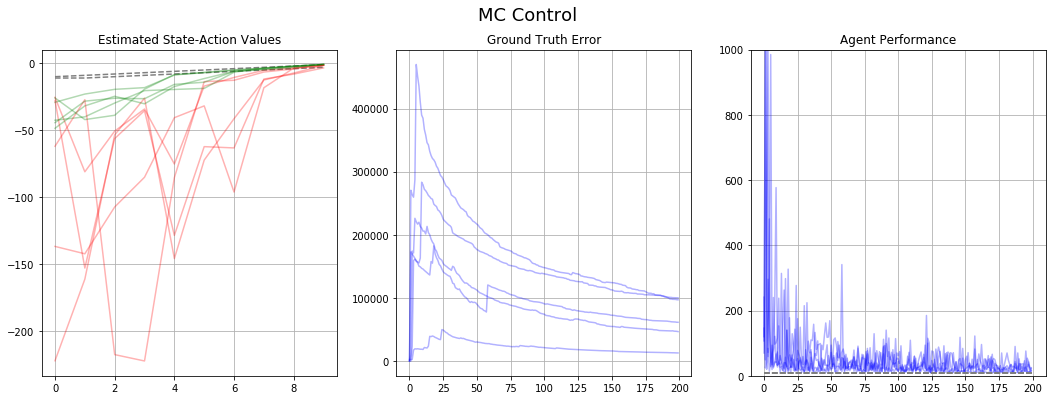

In [13]:
log = []
for _ in range(5):
    hist, perf = mc_control(env, pi_random, N=200, alpha=0.01, eps=0.1)
    log.append(LogEntry('mc', hist, perf))
plot_experiments(log, REF_GREEDY, 'MC Control')

# TD Prediction

As for MC, this is Q-Value version of temporal-difference algorithm from [lecture 4](../Lecture04_Pred/ModelFreePrediction_Part1.ipynb#Offline-Temporal-Difference Learning).

Changes are as follows:
* track Q-values (2d array) instead of V (1d-array)
* update Q instead of V
* track history for plotting

In [14]:
def td_prediction(env, policy, N, alpha):
    hist, perf = [], []
    # V = np.zeros(obs_shape)  # old code
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    
    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            
            # St, _, _, _ = trajectory[t]         # old code
            # St_1, Rt_1, _, _ = trajectory[t+1]  # old code
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            
            # V[St] = V[St] + alpha*(Rt_1 + disc*V_St_1 - V[St])  # old code
            target = Rt_1 + 1.0 * Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])

        hist.append(Q.copy())
        perf.append(len(trajectory)-1)
    return np.array(hist), np.array(perf)

And let's evaluate random policy

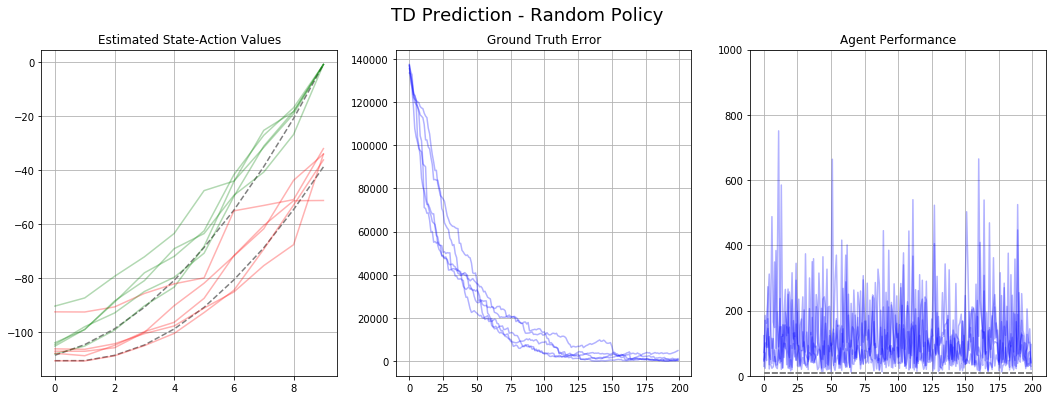

In [15]:
log = []
for _ in range(5):
    hist, perf = td_prediction(env, pi_random, N=200, alpha=0.2)
    log.append(LogEntry('td', hist, perf))
plot_experiments(log, REF_RANDOM, 'TD Prediction - Random Policy')

# SARSA

In [16]:
def sarsa(env, policy, N, alpha, eps):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = Rt_1 + 1.0 * Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
            
        policy = make_eps_greedy(Q, eps)  # Make policy e-greedy

        hist.append(Q.copy())
        perf.append(len(trajectory)-1)
    return np.array(hist), np.array(perf)

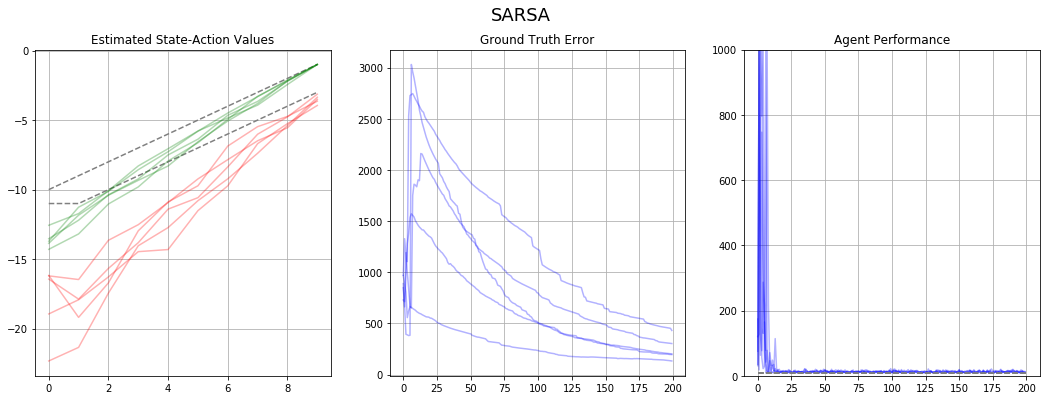

In [17]:
log = []
for _ in range(5):
    hist, perf = sarsa(env, pi_random, N=200, alpha=0.1, eps=0.1)
    log.append(LogEntry('sarsa', hist, perf))
plot_experiments(log, REF_GREEDY, 'SARSA')

# N-Step SARSA

In [18]:
def calc_Gt(trajectory, Q, t, disc, nstep=float('inf')):
    """Calculates return for state t, using n future steps.
    Params:
        traj - complete trajectory, each time-step should be tuple:
            (observation, reward, done, action)
        Q (float arr) - state-action-values, Q[term_state,:] must be zero!
        t (int [t, T-1]) - calc Gt for this time step in trajectory,
            0 is initial state; T-1 is last non-terminal state
        disc - discrount, usually noted as gamma
        n (int or +inf, [1, +inf]) - n-steps of reward to accumulate
                If n >= T then calculate full return for state t
                For n == 1 this equals to TD return
                For n == +inf this equals to MC return
    """

    T = len(trajectory)-1   # terminal state
    max_j = min(t+nstep, T) # last state iterated, inclusive
    tmp_disc = 1.0          # this will decay with rate disc
    Gt = 0                  # result

    # Iterate from t+1 to t+nstep or T (inclusive on both start and finish)
    for j in range(t+1, max_j+1):
        Rj = trajectory[j][1]  # traj[j] is (obs, reward, done, action)
        Gt += tmp_disc * Rj
        tmp_disc *= disc

    # Note that Q[Sj, Aj] will have state-value of state t+nstep or
    # zero if t+nstep >= T as V[St=T] must equal 0
    Sj, _, _, Aj = trajectory[j]  # traj[j] is (obs, reward, done, action)
    Gt += tmp_disc * Q[Sj, Aj]

    return Gt

In [19]:
def nstep_sarsa(env, policy, N, alpha, eps, nstep):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            Gt = calc_Gt(trajectory, Q, t, disc=1.0, nstep=nstep)
            target = Gt
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        policy = make_eps_greedy(Q, eps)
        
        hist.append(Q.copy())
        perf.append(len(trajectory))
        
    return np.array(hist), np.array(perf)

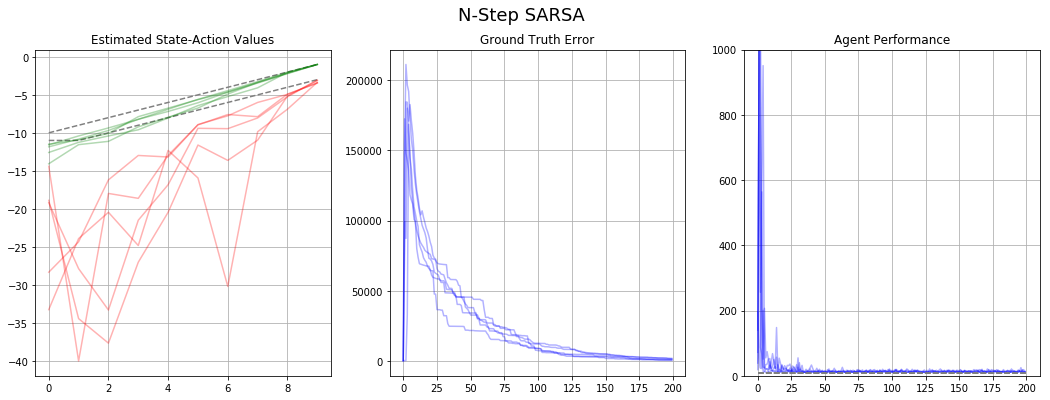

In [20]:
log = []
for _ in range(5):
    hist, perf = nstep_sarsa(env, pi_random, N=200, alpha=0.1, eps=0.1, nstep=10)
    log.append(LogEntry('nstep_sarsa', hist, perf))
plot_experiments(log, REF_GREEDY, 'N-Step SARSA')

# Forward View SARSA(λ)

This is by far not an optimal way to implement this in python, but I think optimizations would just muddy the water too much. I don't recommend running it with λ set to 1, it will take ages to complete.

In [21]:
def sarsa_lambda_fwd(env, policy, N, alpha, eps, lmbda):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            lambda_trunctuate = 1e-3  # optional optimization
            St, _, _, At = trajectory[t]
            Gt_lambda = 0
            T = len(trajectory)-1  # terminal state
            max_n = T-t-1          # inclusive
            
            # Left-hand side of equation
            lmbda_iter = 1         # decays with rate lmbda
            for nstep in range(1, max_n+1):
                Gtn = calc_Gt(trajectory, Q, t, disc=1.0, nstep=nstep)
                Gt_lambda += lmbda_iter * Gtn
                lmbda_iter *= lmbda
                if lmbda_iter < lambda_trunctuate:  # optional optimization
                    break                           # optional optimization
            Gt_lambda *= (1 - lmbda)
            
            # Right-hand side of equation
            if lmbda_iter >= lambda_trunctuate:                                # "if" is optional
                Gt_lambda += lmbda_iter * calc_Gt(trajectory, Q, t, disc=1.0)  # but this stays!
            
            Q[St, At] = Q[St, At] + alpha * (Gt_lambda - Q[St, At])
        policy = make_eps_greedy(Q, eps)
        
        hist.append(Q.copy())
        perf.append(len(trajectory))
        
    return np.array(hist), np.array(perf)

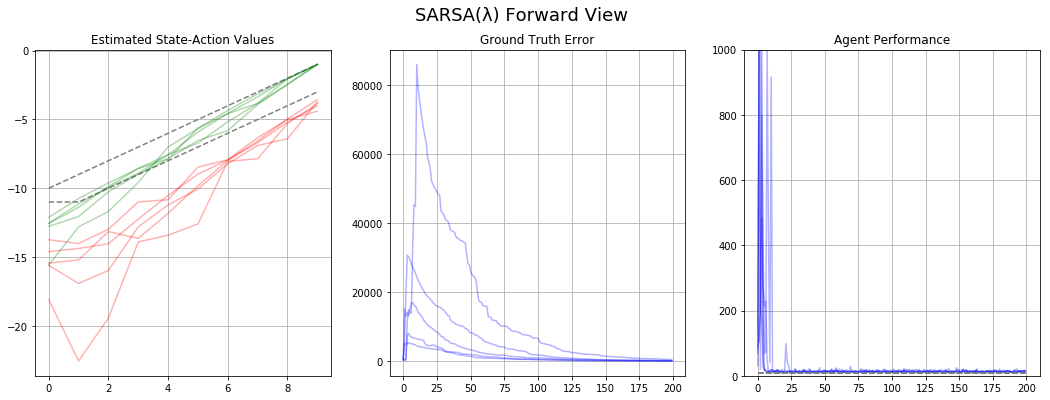

In [22]:
log = []
for _ in range(5):
    hist, perf = sarsa_lambda_fwd(env, pi_random, N=200, alpha=0.2, eps=0.1, lmbda=0.4)
    log.append(LogEntry('sarsa_lambda_fwd', hist, perf))
plot_experiments(log, REF_GREEDY, 'SARSA(λ) Forward View')

# Backward View SARSA(λ)

In [23]:
def sarsa_lambda_bwd(env, policy, N, alpha, lmbda, eps):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    E = np.zeros(shape=[env.nb_st, env.nb_act])  # eligibility traces
    
    for ep in range(N):
        E *= 0                              # reset every new episode
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):  # never evaluate terminal states (see note #3)
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
                        
            E *= lmbda  # decay
            E[St, At] += 1  # increment
                        
            ro_t = Rt_1 + 1.0 * Q[St_1, At_1] - Q[St, At]            
            Q += alpha * ro_t * E
            
        policy = make_eps_greedy(Q, eps)
        
        hist.append(Q.copy())
        perf.append(len(trajectory))
    return np.array(hist), np.array(perf)

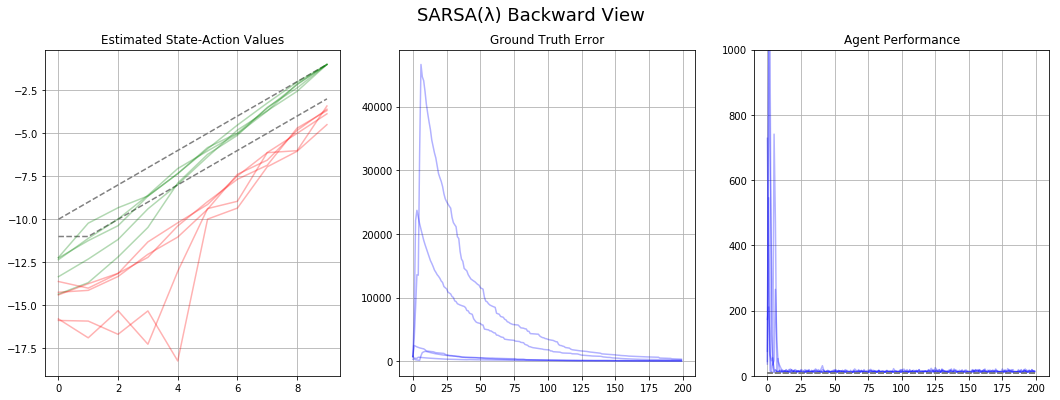

In [24]:
log = []
for _ in range(5):
    hist, perf = sarsa_lambda_bwd(env, pi_random, N=200, alpha=0.2, lmbda=0.4, eps=0.1)
    log.append(LogEntry('sarsa_lambda_bwd', hist, perf))
plot_experiments(log, REF_GREEDY, 'SARSA(λ) Backward View')

# Online SARSA

There are two slightly different ways to implement online SARSA:
* Option 1: use the same action both for learning and control - this is classic SARSA described in the books
* Option 2: select temporary action for learning, update policy, then select again using updated policy
* Both approaches are virtually identical, option 2 is more similar to Q-learning and expected SARSA, where learning and action selection are decoupled

In [25]:
def sarsa_online(env, policy, N, alpha, eps):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    
    for ep in range(N):
        trajectory = []
        done = True
        while True:
            # === time step starts ===
            if done:
                obs, reward, done = env.reset(), None, False
            else:
                obs, reward, done = env.step(action)
                
            # option #1, same action for learning and control - standard SARSA
            action = np.random.choice([0, 1], p=policy[obs])
            
            # perform TD update from the perspective of previous step
            # PREVIOUS STEP is t, CURRENT STEP is t+1
            if len(trajectory) >= 2:
                St, _, _, At = trajectory[-1]
                St_1, Rt_1, At_1 = obs, reward, action
                Q[St, At] = Q[St, At] + alpha * (Rt_1 + Q[St_1, At_1] - Q[St, At])
                
                policy = make_eps_greedy(Q, eps)

            # option #2, pick action again with updated policy
            # action = np.random.choice([0, 1], p=policy[obs])
            
            trajectory.append((obs, reward, done, action))
            if done: break
            # === time step ends here ===
        hist.append(Q.copy())
        perf.append(len(trajectory))
    return np.array(hist), np.array(perf)

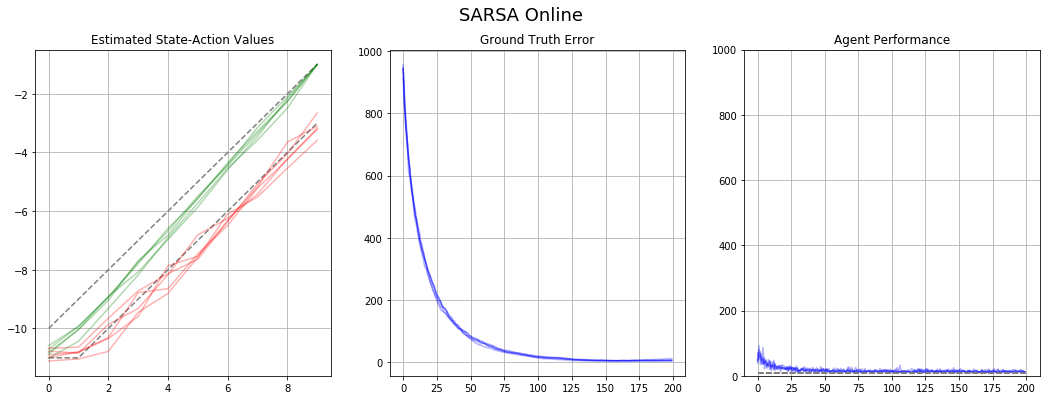

In [26]:
log = []
for _ in range(5):
    hist, perf = sarsa_online(env, pi_random, N=200, alpha=0.1, eps=0.1)
    log.append(LogEntry('sarsa_online', hist, perf))
plot_experiments(log, REF_GREEDY, 'SARSA Online')

# Online Backward View SARSA(λ)

In [27]:
def sarsa_lambda_online(env, policy, N, alpha, lmbda, eps):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    E = np.zeros(shape=[env.nb_st, env.nb_act])  # eligibility traces
    
    for ep in range(N):
        E *= 0
        trajectory = []
        done = True
    
        while True:
            # === time step starts ===
            if done:
                obs, reward, done = env.reset(), None, False
            else:
                obs, reward, done = env.step(action)
                            
            # option #1, same action for learning and control - standard SARSA
            action = np.random.choice([0, 1], p=policy[obs])
                    
            # perform TD update from the perspective of previous step
            # PREVIOUS STEP is t, CURRENT STEP is t+1
            if len(trajectory) >= 2:
                St, _, _, At = trajectory[-1]
                St_1, Rt_1, At_1 = obs, reward, action
                                
                E *= lmbda  # decay
                E[St, At] += 1  # increment
                ro_t = Rt_1 + 1.0 * Q[St_1, At_1] - Q[St, At] 
                Q += alpha * ro_t * E
            
                policy = make_eps_greedy(Q, eps)
            
            # option #2, pick again using updated policy
            # action = np.random.choice([0, 1], p=policy[obs])           

            trajectory.append((obs, reward, done, action))
            if done: break
            # === time step ends here ===
        hist.append(Q.copy())
        perf.append(len(trajectory))
    return np.array(hist), np.array(perf)

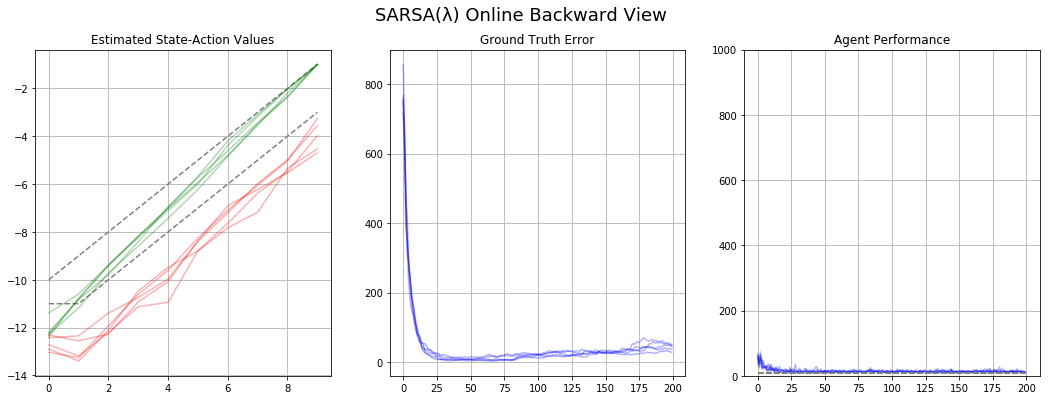

In [28]:
log = []
for _ in range(5):
    hist, perf = sarsa_lambda_online(env, pi_random, N=200, alpha=0.2, lmbda=0.4, eps=0.1)
    log.append(LogEntry('sarsa_lambda_bwd_online', hist, perf))
plot_experiments(log, REF_GREEDY, 'SARSA(λ) Online Backward View')

# Generate REF_RANDOM

Incremental MC for accurate estimate

In [29]:
def mc_prediction_inc(env, policy, N):
    hist, perf = [], []
    
    C = np.zeros([env.nb_st, env.nb_act])   # count state visits (see note #1)
    Q = np.zeros([env.nb_st, env.nb_act])   # state-values

    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            Gt = -(len(trajectory)-t-1)
            St, _, _, At = trajectory[t]
            C[St, At] += 1
            Q[St, At] = Q[St, At] + (1/C[St, At]) * (Gt - Q[St, At])

        hist.append(Q.copy())
        perf.append(len(trajectory)-1)  # don't count terminal state
        
        if ep % 1000 == 0:
            print('ep', ep)
    return np.array(hist), np.array(perf)

This will take long to run

In [30]:
# log = []
# for _ in range(1):
#     hist, perf = mc_prediction_inc(env, pi_random, N=100000)
#     log.append(LogEntry('mc inc', hist, perf))
# plot_experiments(log, REF_RANDOM, 'MC Prediction Inc - Random Policy')
# print(hist[-1])